# Q1

In [8]:
import torch

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [9]:
# ! unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [10]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [11]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [12]:
class NamesDataset(Dataset):\n\n    def __init__(self, data_dir=None, file_path=None, delimiter=None, label_col=0, line_col=1):\n        # Generalizing to handle both directory of files and single delimited file\n        import glob, os, time\n        self.load_time = time.localtime\n        labels_set = set()\n\n        self.data = []\n        self.data_tensors = []\n        self.labels = []\n        self.labels_tensors = []\n\n        if file_path:\n            # Single file mode (CSV/TSV/etc)\n            import csv\n            with open(file_path, encoding='utf-8') as f:\n                # Auto-detect delimiter if not provided\n                try:\n                    sample = f.read(1024)\n                    f.seek(0)\n                    dialect = csv.Sniffer().sniff(sample)\n                    delimiter = dialect.delimiter\n                except:\n                    delimiter = delimiter or ','\n                \n                reader = csv.reader(f, delimiter=delimiter)\n                for row in reader:\n                    if len(row) > max(label_col, line_col):\n                        label = row[label_col]\n                        name = row[line_col]\n                        labels_set.add(label)\n                        self.data.append(name)\n                        self.data_tensors.append(lineToTensor(name))\n                        self.labels.append(label)\n        elif data_dir:\n            # Directory mode (Original behavior)\n            text_files = glob.glob(os.path.join(data_dir, '*.txt'))\n            for filename in text_files:\n                label = os.path.splitext(os.path.basename(filename))[0]\n                labels_set.add(label)\n                lines = open(filename, encoding='utf-8').read().strip().split('\n')\n                for name in lines:\n                    self.data.append(name)\n                    self.data_tensors.append(lineToTensor(name))\n                    self.labels.append(label)\n        else:\n            raise ValueError("Either data_dir or file_path must be provided")\n\n        # Cache the tensor representation of the labels\n        self.labels_uniq = list(labels_set)\n        for idx in range(len(self.labels)):\n            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)\n            self.labels_tensors.append(temp_tensor)\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        return self.labels_tensors[idx], self.data_tensors[idx], self.labels[idx], self.data[idx]

In [13]:
alldata = NamesDataset(data_dir="data/names")\nprint(f"loaded {len(alldata)} items of data")\nprint(f"example = {alldata[0]}")\n\n# To try with a different dataset (e.g., CSV with label in col 1 and text in col 0):\n# other_data = NamesDataset(file_path="path/to/data.csv", delimiter=",", label_col=1, line_col=0)\n# run_experiment_with_data(other_data, rnn_type='LSTM')

loaded 20074 items of data
example = (tensor([4], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.,

In [14]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


In [15]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='RNN', n_layers=1, extra_layers=0):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn_type = rnn_type

        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, n_layers)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, n_layers)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, n_layers)

        self.linears = nn.ModuleList()
        curr_size = hidden_size
        for _ in range(extra_layers):
            self.linears.append(nn.Linear(curr_size, curr_size))
            self.linears.append(nn.ReLU())
        
        self.h2o = nn.Linear(curr_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        
        # For LSTM/GRU/RNN, we take the last hidden state of the last layer
        if self.rnn_type == 'LSTM':
            # hidden is (h_n, c_n), we want h_n
            output = hidden[0][-1]
        else:
            # hidden is h_n
            output = hidden[-1]
            
        for layer in self.linears:
            output = layer(output)
            
        output = self.h2o(output)
        output = self.softmax(output)

        return output

In [16]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [17]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.9754, -3.0785, -2.8300, -2.8736, -2.9182, -2.7799, -2.7800, -2.9330,
         -2.9348, -2.9346, -2.8457, -2.8184, -2.8562, -2.7817, -2.8975, -2.8152,
         -2.9919, -3.0505]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('French', 5)


In [18]:
def train(rnn, training_data, n_epoch = 10, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) //n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

tune


In [19]:
def run_experiment_with_data(dataset, rnn_type='RNN', n_hidden=128, n_layers=1, extra_layers=0, n_epoch=10, learning_rate=0.2, n_batch_size=64):\n    # Helper to run experiments with specific datasets\n    train_s, test_s = torch.utils.data.random_split(dataset, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))\n    \n    print(f"\n--- Experiment with {len(dataset)} items ---")\n    print(f"Architectue: {rnn_type}, hidden={n_hidden}, layers={n_layers}")\n    \n    model = CharRNN(n_letters, n_hidden, len(dataset.labels_uniq), rnn_type=rnn_type, n_layers=n_layers, extra_layers=extra_layers)\n    model.to(device)\n    \n    losses = train(model, train_s, n_epoch=n_epoch, n_batch_size=n_batch_size, learning_rate=learning_rate, report_every=max(1, n_epoch//5))\n    \n    # Accuracy on test set\n    model.eval()\n    correct = 0\n    with torch.no_grad():\n        for i in range(len(test_s)):\n            (label_tensor, text_tensor, label, text) = test_s[i]\n            output = model(text_tensor)\n            guess, guess_i = label_from_output(output, dataset.labels_uniq)\n            if guess == label: correct += 1\n    \n    print(f"Validation Accuracy: {correct/len(test_s):.4f}")\n    return model, losses

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.8852132905487934
10 (37%): 	 average batch loss = 0.6989270468076023
15 (56%): 	 average batch loss = 0.5775303571606178
20 (74%): 	 average batch loss = 0.4976161484983079
25 (93%): 	 average batch loss = 0.43971793635119727
training took 480.5929021835327s


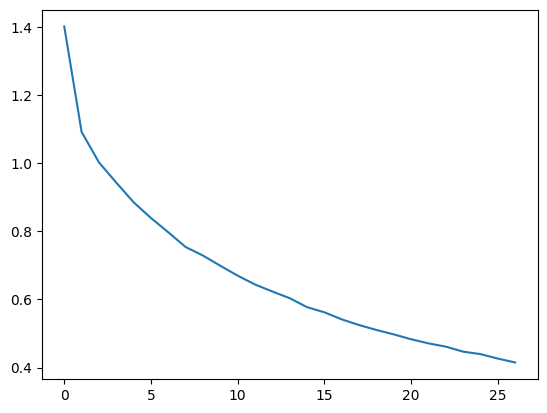

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

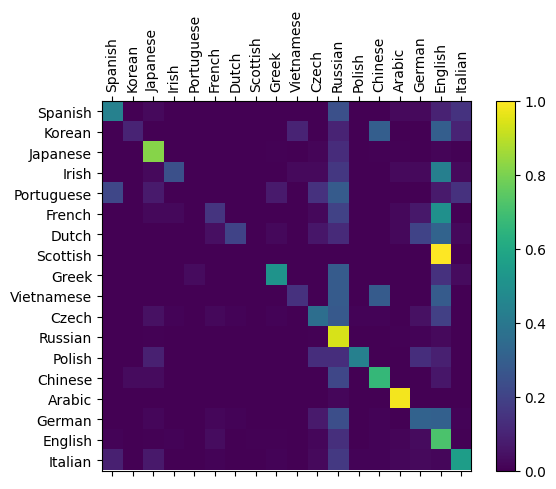

In [22]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)